In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Load the exemplary image

In [6]:
img_example = cv.imread('dataset/without_mask/0.jpg')

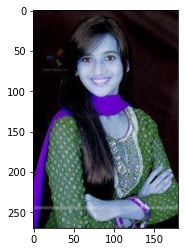

In [7]:
plt.imshow(img_example)

As can be seen, the colors are probably swapped - matplotlib and openCV have different color channels order. Therefore, for the display purposes, I use a function that will correct the displayed image.

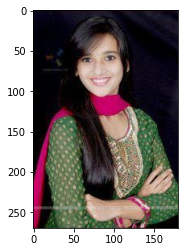

In [11]:
img_display = cv.cvtColor(img_example, cv.COLOR_BGR2RGB)
plt.imshow(img_display)

That is much better. Now I can go on and apply face detection - there is no need to look for a face mask beyond this region after all: this way, after the model detects the face, I can crop the image before giving in to the mask detection model, which will speed up its execution time.

## Face detection

For this task, I will use Cascade classifier provided by openCV, as well as their frontal face d. To actually use this, I have to convert my image to the greyscale.

In [13]:
img_gray = cv.cvtColor(img_example, cv.COLOR_BGR2GRAY)

In [ ]:
face_detector = cv.CascadeClassifier('data/haarcascade/haarcascade_frontalface_default.xml')